In [1]:
import os
from abc import ABC, abstractmethod
from dataclasses import dataclass
from typing import Any

import networkx as nx
import pandas as pd
from dwave.system import LeapHybridCQMSampler
from matplotlib import pyplot as plt
import scipy.stats as stats

from QHyper.problems.algorithms.graph_utils import is_sp_dag
from QHyper.problems.algorithms.solver_utils import WorkflowSchedulingSolverDecorator, \
    DecomposedWorkflowSchedulingSolver, WorkflowSchedule
from QHyper.problems.algorithms.spization import SpIzationAlgorithm, JavaFacadeSpIzationAlgorithm
from QHyper.problems.algorithms.utils import draw
from QHyper.problems.algorithms.workflow_decomposition import SeriesParallelSplitFinal
from QHyper.problems.workflow_scheduling import Workflow, WorkflowSchedulingOneHot
from QHyper.solvers import Gurobi, solver_from_config, CQM
from QHyper.solvers.converter import Converter
from QHyper.solvers.cqm.cqm import DWAVE_API_TOKEN
from demo.reports.report import ExecutionReport, Solution

# Scheduling

### Override CQM solver

In [56]:
class SolutionCQM:
    def __init__(self, cqm, solutions):
        self.cqm = cqm
        self.solutions = solutions
        self.correct_solutions = self._correct_solutions()
        self.violated_solutions = self._violated_solutions()
        
    def _is_correct_solution(self, solution):
        return len(self.cqm.violations(solution, skip_satisfied=True)) == 0
    
    def _correct_solutions(self):
        return [s for s in self.solutions if self._is_correct_solution(s)]
    
    def _violated_solutions(self):
        return [s for s in self.solutions if not self._is_correct_solution(s)]
    
    def energy_correctness_pairs(self):
        return [(e, c) for e, c in zip(self.solutions.record.energy, self.solutions.record.is_feasible)]
            

class DetailedCQM(CQM):
    def solve(self, params_inits: dict[str, Any] = {}) -> SolutionCQM:
        converter = Converter()
        cqm = converter.to_cqm(self.problem)
        sampler = LeapHybridCQMSampler(token=DWAVE_API_TOKEN)
        solutions = sampler.sample_cqm(cqm, self.time)
        return SolutionCQM(cqm, solutions)

In [57]:
class ExperimentResult(ABC):
    @abstractmethod
    def plot(self):
        pass
    
    @abstractmethod
    def save_as_json(self):
        pass

@dataclass
class AlgorithmRun:
    max_subgraph_size: int
    decomposition_schedule: WorkflowSchedule
    reference_schedule: WorkflowSchedule

class SolverFactory(ABC):
    def __init__(self, tasks_file, machines_file, deadline):
        self.tasks_file = tasks_file
        self.machines_file = machines_file
        self.deadline = deadline
    
    @abstractmethod
    def get_decomposed_solver(self, max_subgraph_size: int):
        pass
    
    @abstractmethod
    def get_reference_solver(self):
        pass
    
class GurobiSolverFactory(SolverFactory):
    def get_decomposed_solver(self, max_subgraph_size: int):
        workflow = Workflow(self.tasks_file, self.machines_file, self.deadline)
        division = SeriesParallelSplitFinal().decompose(workflow, max_subgraph_size)
        problems = map(lambda w: WorkflowSchedulingOneHot(w), division.workflows)
        solvers = map(lambda p: WorkflowSchedulingSolverDecorator(Gurobi(p)), problems)
        return DecomposedWorkflowSchedulingSolver(list(solvers), division)

    def get_reference_solver(self):
        solver_config = {
            "problem": {
                "type": "workflow_scheduling",
                "encoding": "one-hot",
                "tasks_file": self.tasks_file,
                "machines_file": self.machines_file,
                "deadline": self.deadline,
            },
            "solver": {
                "type": "gurobi",
            }
        }
        return WorkflowSchedulingSolverDecorator(solver_from_config(solver_config))

class CQMSolverFactory(SolverFactory):
    def __init__(self, tasks_file, machines_file, deadline, time=5):
        super().__init__(tasks_file, machines_file, deadline)
        self.time=time

    def get_decomposed_solver(self, max_subgraph_size: int):
        workflow = Workflow(self.tasks_file, self.machines_file, self.deadline)
        division = SeriesParallelSplitFinal().decompose(workflow, max_subgraph_size)
        problems = map(lambda w: WorkflowSchedulingOneHot(w), division.workflows)
        solvers = map(lambda p: WorkflowSchedulingSolverDecorator(CQM(problem=p, time=self.time)), problems)
        return DecomposedWorkflowSchedulingSolver(list(solvers), division)

    def get_reference_solver(self):
        solver_config = {
            "problem": {
                "type": "workflow_scheduling",
                "encoding": "one-hot",
                "tasks_file": self.tasks_file,
                "machines_file": self.machines_file,
                "deadline": self.deadline,
            },
            "solver": {
                "type": "cqm",
                "time": self.time
            }
        }
        return WorkflowSchedulingSolverDecorator(solver_from_config(solver_config))


class Experiment(ABC):
    def __init__(self, tasks_file, machines_file, deadline):
        self.tasks_file = tasks_file
        self.machines_file = machines_file
        self.deadline = deadline


    @abstractmethod
    def run(self) -> ExperimentResult:
        pass


class CQMPerformanceExperiment(Experiment):
    class CQMExperimentResult(ExperimentResult):
        def __init__(self, gurobi_scheduling: AlgorithmRun, cqm_scheduling: AlgorithmRun):
            self.gurobi_scheduling: AlgorithmRun = gurobi_scheduling
            self.cqm_scheduling: AlgorithmRun = cqm_scheduling
        
        @staticmethod
        def _calculate_cost_increase_ratio(algorithm_run: AlgorithmRun) -> float:
            return algorithm_run.decomposition_schedule.cost / algorithm_run.reference_schedule.cost
        
        def plot(self):
            pass
        
    def __init__(self, tasks_file, machines_file, max_subgraph_size: int):
        super().__init__(tasks_file, machines_file, deadline_as_cpv(tasks_file, machines_file))
        self.max_subgraph_size: int = max_subgraph_size
        self.gurobi_factory: SolverFactory = GurobiSolverFactory(self.tasks_file, self.machines_file, self.deadline)
        self.cqm_factory: SolverFactory = CQMSolverFactory(self.tasks_file, self.machines_file, self.deadline)

    def run(self) -> CQMExperimentResult:
        gurobi_run = AlgorithmRun(
            self.max_subgraph_size, 
            self.gurobi_factory.get_decomposed_solver(self.max_subgraph_size).solve(), 
            self.gurobi_factory.get_reference_solver().solve()
        )
        cqm_run = AlgorithmRun(
            self.max_subgraph_size, 
            None, 
            self.cqm_factory.get_reference_solver().solve()
        )
        return self.CQMExperimentResult(gurobi_run, cqm_run)

def deadline_as_cpv(tasks_file, machines_file):
    workflow = Workflow(tasks_file, machines_file, 100000)
    return int(workflow.critical_path_value)

# Test single instance

In [58]:
workflows = [
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-6ch-100k-001.json", # 156 nodes
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-12ch-250k-001.json", # 492 nodes
  "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-22ch-250k-001.json" # 902 nodes
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"

In [59]:
epigenomics_1397 = "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-ilmn-5seq-50k-001.json"

In [61]:
montage_472 = "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-10d-001.json" # cqm requires min ~10s
montage_58 = "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-05d-001.json" # cqm requires 5s
montage_178 = "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-075d-001.json" # cqm requires 5s
montage_310 = "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-015d-001.json" # cqm requires 5s
montage_103 = "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-01d-001.json" # cqm requires 5s
montage_619 = "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-025d-001.json"
montage_1066 = "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-125d-001.json"

In [34]:
cycles_2182 = "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-5l-2c-12p-001.json"
cycles_6543 = "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-10l-3c-12p-001.json"

In [62]:
print(deadline_as_cpv(montage_1066, machines_file))

25945


In [63]:
tasks_file = montage_1066

In [64]:
cqm_solver = CQMSolverFactory(tasks_file, machines_file, deadline_as_cpv(tasks_file, machines_file))
# cqm_solver = CQMSolverFactory(tasks_file, machines_file, 3500)
gurobi_solver = GurobiSolverFactory(tasks_file, machines_file, deadline_as_cpv(tasks_file, machines_file))
# gurobi_solver = GurobiSolverFactory(tasks_file, machines_file, 3500)

In [67]:
gurobi_schedule = gurobi_solver.get_reference_solver().solve()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


Consider calling update less frequently.

Optimize a model with 181366 rows, 5330 columns and 6762080 nonzeros
Model fingerprint: 0xa1b0a0f6
Variable types: 0 continuous, 5330 integer (5330 binary)
Coefficient statistics:
  Matrix range     [9e-02, 3e+04]
  Objective range  [2e-01, 7e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+04]
Found heuristic solution: objective 3572005.4574
Presolve removed 122710 rows and 64 columns (presolve time = 5s) ...
Presolve removed 125572 rows and 2764 columns (presolve time = 10s) ...
Presolve removed 138030 rows and 3301 columns (presolve time = 15s) ...
Presolve removed 138011 rows and 3282 columns
Presolve time: 15.71s
Presolved: 43355 rows, 2048 columns, 1366928 nonzeros
Found heuristic solution: objectiv

In [65]:
gurobi_schedule_decomposed = gurobi_solver.get_decomposed_solver(350).solve()

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (linux64)

CPU model: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 52 rows, 135 columns and 260 nonzeros
Model fingerprint: 0x9e8bc91b
Variable types: 0 continuous, 135 integer (135 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+04]
  Objective range  [2e+04, 7e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+04]
Found heuristic solution: objective 1318997.3243
Presolve removed 52 rows and 135 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 8 available processors)

Solution count 2: 1.13608e+06 1.319e+06 

Optimal solution found (tolerance 1.00e-04)
Best objective 1.136081959416e+06, best bound 1.136081959416e+06, gap 0.0000%
Gurobi Optimizer version 10.0.3 bui

In [40]:
print(gurobi_schedule_decomposed.cost/gurobi_schedule.cost)

1.013818644819892


In [95]:
cqm_schedule_no_div = cqm_solver.get_reference_solver().solve()

IndexError: list index out of range

In [65]:
print(cqm_schedule_no_div.cost/gurobi_schedule.cost)

1.0003876817178827


In [66]:
cqm_schedule_decomposed = cqm_solver.get_decomposed_solver(350).solve()

In [42]:
print(cqm_schedule_decomposed.cost/gurobi_schedule.cost)

1.0138189487555502


In [43]:
print(cqm_schedule_decomposed.cost / gurobi_schedule_decomposed.cost)

1.0000002997929263


In [44]:
save_dir = "cqm_scheduling"

In [67]:
report = ExecutionReport(
    workflow_file=tasks_file,
    machines_file=machines_file,
    deadline=deadline_as_cpv(tasks_file, machines_file),
    solver="CQM",
    solution=Solution.from_workflow_schedule(cqm_schedule_no_div)
)
report.write_json(os.path.join(save_dir, "cqm", "montage_472.json"))

In [68]:
report = ExecutionReport(
    workflow_file=tasks_file,
    machines_file=machines_file,
    deadline=deadline_as_cpv(tasks_file, machines_file),
    solver="CQM",
    solution=Solution.from_workflow_schedule(cqm_schedule_decomposed)
)
report.write_json(os.path.join(save_dir, "cqm", "montage_1066_decomposed_mss_350.json"))

In [69]:
report = ExecutionReport(
    workflow_file=tasks_file,
    machines_file=machines_file,
    deadline=deadline_as_cpv(tasks_file, machines_file),
    solver="Gurobi",
    solution=Solution.from_workflow_schedule(gurobi_schedule)
)
report.write_json(os.path.join(save_dir, "gurobi", "montage_1066.json"))

In [70]:
report = ExecutionReport(
    workflow_file=tasks_file,
    machines_file=machines_file,
    deadline=deadline_as_cpv(tasks_file, machines_file),
    solver="Gurobi",
    solution=Solution.from_workflow_schedule(gurobi_schedule_decomposed)
)
report.write_json(os.path.join(save_dir, "gurobi", "montage_1066_decomposed_mss_350.json"))

# Collect energies for Montage 310

In [33]:
tasks_file = montage_310
deadline = deadline_as_cpv(montage_310, machines_file)
wsp = WorkflowSchedulingOneHot(Workflow(tasks_file, machines_file, deadline))
cqm = DetailedCQM(wsp, time=5)

In [36]:
cqm_solution: SolutionCQM = cqm.solve({})

In [48]:
cqm_solution.energy_correctness_pairs()

[(63045.54432000033, False),
 (64373.49504000033, False),
 (65136.37248000034, False),
 (65906.70624000035, False),
 (66127.22784000034, False),
 (66154.23936000031, False),
 (66456.45216000034, False),
 (66956.99616000039, False),
 (67120.11072000048, False),
 (67311.09792000047, False),
 (67348.86336000044, False),
 (67439.4336000005, False),
 (67838.93856000056, False),
 (68220.60768000054, False),
 (68776.83648000057, False),
 (68789.41056000056, False)]

# Test decomposition on Cyfronet machines

In [48]:
def get_decomposed_solver(tasks_file, machines_file, deadline, max_graph_size: int):
    workflow = Workflow(tasks_file, machines_file, deadline)
    division = SeriesParallelSplitFinal().decompose(workflow, max_graph_size)
    problems = map(lambda w: WorkflowSchedulingOneHot(w), division.workflows)
    solvers = map(lambda p: WorkflowSchedulingSolverDecorator(Gurobi(p)), problems)
    return DecomposedWorkflowSchedulingSolver(list(solvers), division)

def deadline_as_cpv(tasks_file, machines_file):
    workflow = Workflow(tasks_file, machines_file, 100000)
    return int(workflow.critical_path_value)

In [49]:
tasks_file = "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-125d-001.json"
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
deadline = deadline_as_cpv(tasks_file, machines_file)

#mss 160 - 17000 constraints, montage 310
#mss 200 - 30879 constraints, montage 472
#mss 150 - 2059 constraints, montage 472
#mss 200 - 4470 constraints, 7 parts, montage 619
#mss 400 - 187000 constraints, 4 parts, montage 1066

In [50]:
print(deadline)

25945


In [51]:
solver_factory = GurobiSolverFactory(tasks_file, machines_file, deadline)

In [26]:
reference_solver = solver_factory.get_reference_solver()

In [54]:
decomposition_solver = solver_factory.get_decomposed_solver(350) # 350 ok

KeyboardInterrupt: 

In [37]:
cqm_solver_factory = CQMSolverFactory(tasks_file, machines_file, deadline)

In [38]:
cqm_decomposition_solver = cqm_solver_factory.get_decomposed_solver(160)

In [39]:
def schedule_cqm(cqm_solvers: list[WorkflowSchedulingSolverDecorator]):
    schedules: dict = {}
    for s in cqm_solvers:
        try:
            schedules[s] = s.solve()
        except Exception as e:
            print(f"Could not solve problem that had {len(s.problem.constraints)} constraints")
    return schedules

In [40]:
cqm_schedules_map = schedule_cqm(cqm_decomposition_solver.solvers)

Could not solve problem that had 17001 constraints
Could not solve problem that had 17001 constraints
Could not solve problem that had 17001 constraints


In [41]:
cqm_schedules_map.items()

dict_items([(<QHyper.problems.algorithms.solver_utils.WorkflowSchedulingSolverDecorator object at 0x7fda79afae90>, WorkflowSchedule(cost=19.376640000000002, time=4.6848, deadline=4.830392987366948, machine_assignment={'mViewer_ID0000206': 'Machine1', 'NewNode315': 'Machine5', 'mViewer_ID0000310': 'Machine3', 'NewNode311': 'Machine3', 'mViewer_ID0000103': 'Machine1', 'mViewer_ID0000309': 'Machine1'}, workflow=<QHyper.problems.workflow_scheduling.Workflow object at 0x7fda8499c050>, parts=[]))])

In [95]:
%%capture
decomposed_solution = decomposition_solver.solve()
no_div_solution = reference_solver.solve()

In [43]:
print(decomposed_solution.cost / no_div_solution.cost)

1.0195618711066419


In [21]:
def decomposition_to_df(decomposed_solvers: list[WorkflowSchedulingSolverDecorator]):
    def get_problem_dict(problem: WorkflowSchedulingOneHot):
        return {
            'task_count': len(problem.workflow.tasks),
            'deadline': problem.workflow.deadline,
            'paths_count': len(problem.workflow.paths),
            'variables_count': len(problem.variables),
            'constraints_count': len(problem.constraints)
        }
    return pd.DataFrame([get_problem_dict(s.problem) for s in decomposed_solvers])

In [22]:
decomposed_montage_619_df = decomposition_to_df(decomposition_solver.solvers)

In [23]:
decomposed_montage_619_df.to_csv('cqm_scheduling/gurobi/montage_619_decomposed_problems_mss_200.csv')

In [242]:
no_div_solution.machine_assignment

{'mProject_ID0000001': 'Machine2',
 'mProject_ID0000002': 'Machine2',
 'mProject_ID0000003': 'Machine2',
 'mProject_ID0000004': 'Machine2',
 'mProject_ID0000005': 'Machine2',
 'mProject_ID0000006': 'Machine2',
 'mProject_ID0000007': 'Machine2',
 'mProject_ID0000008': 'Machine2',
 'mProject_ID0000009': 'Machine2',
 'mProject_ID0000010': 'Machine2',
 'mProject_ID0000011': 'Machine2',
 'mProject_ID0000012': 'Machine2',
 'mProject_ID0000013': 'Machine2',
 'mProject_ID0000014': 'Machine2',
 'mProject_ID0000015': 'Machine2',
 'mProject_ID0000016': 'Machine2',
 'mDiffFit_ID0000017': 'Machine1',
 'mDiffFit_ID0000018': 'Machine1',
 'mDiffFit_ID0000019': 'Machine1',
 'mDiffFit_ID0000020': 'Machine1',
 'mDiffFit_ID0000021': 'Machine1',
 'mDiffFit_ID0000022': 'Machine1',
 'mDiffFit_ID0000023': 'Machine1',
 'mDiffFit_ID0000024': 'Machine1',
 'mDiffFit_ID0000025': 'Machine1',
 'mDiffFit_ID0000026': 'Machine1',
 'mDiffFit_ID0000027': 'Machine1',
 'mDiffFit_ID0000028': 'Machine1',
 'mDiffFit_ID0000029

In [174]:
is_sp_dag(decomposition_solver.division.complete_workflow.wf_instance.workflow)

True

In [80]:
report = ExecutionReport(
    workflow_file=tasks_file,
    machines_file=machines_file,
    deadline=deadline,
    solver="Gurobi",
    solution=Solution.from_workflow_schedule(no_div_schedule)
)
report.write_json(os.path.join("scheduled_workflows", "no_division", "cycles_3273.json"))

In [157]:
solver = get_decomposed_solver(tasks_file, machines_file, deadline, 50)

In [159]:
workflow_no_division = Workflow(tasks_file, machines_file, deadline)
# workflow_after_division = solver.division.complete_workflow

In [160]:
decomposed_wf = decomposition_solver.division.complete_workflow.wf_instance.workflow
no_division_wf = workflow_no_division.wf_instance.workflow
root = [node for node in no_division_wf.nodes if no_division_wf.in_degree(node) == 0]
leaf = [node for node in no_division_wf.nodes if no_division_wf.out_degree(node) == 0]

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

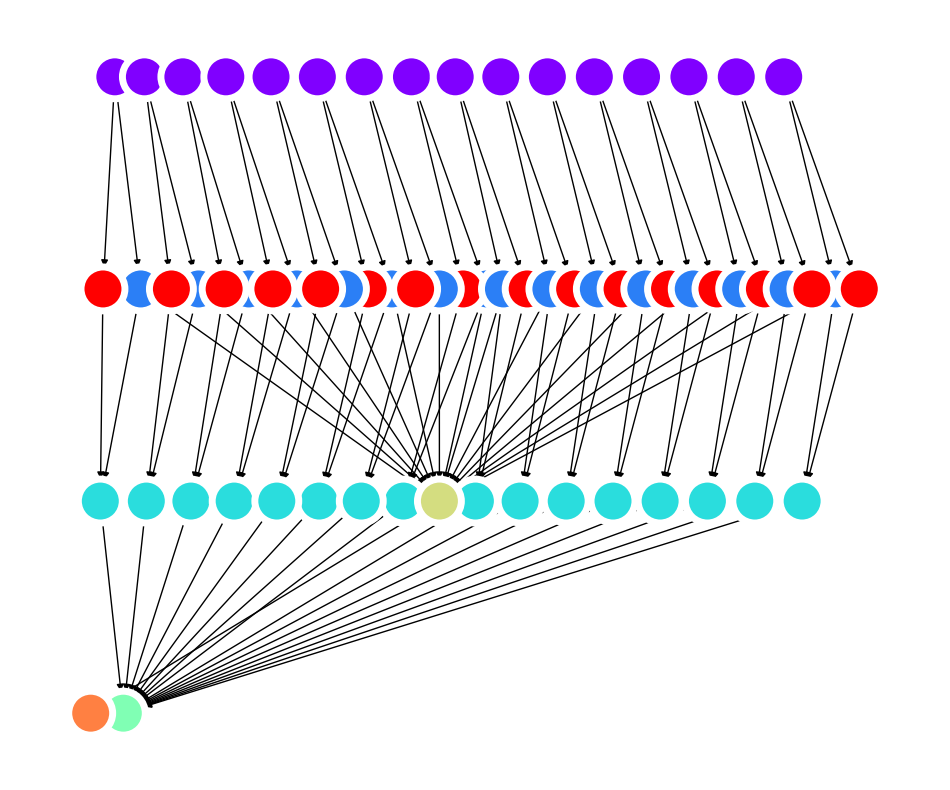

In [154]:
draw(workflow_no_division.wf_instance.workflow)

(<Figure size 1200x1000 with 1 Axes>, <Axes: >)

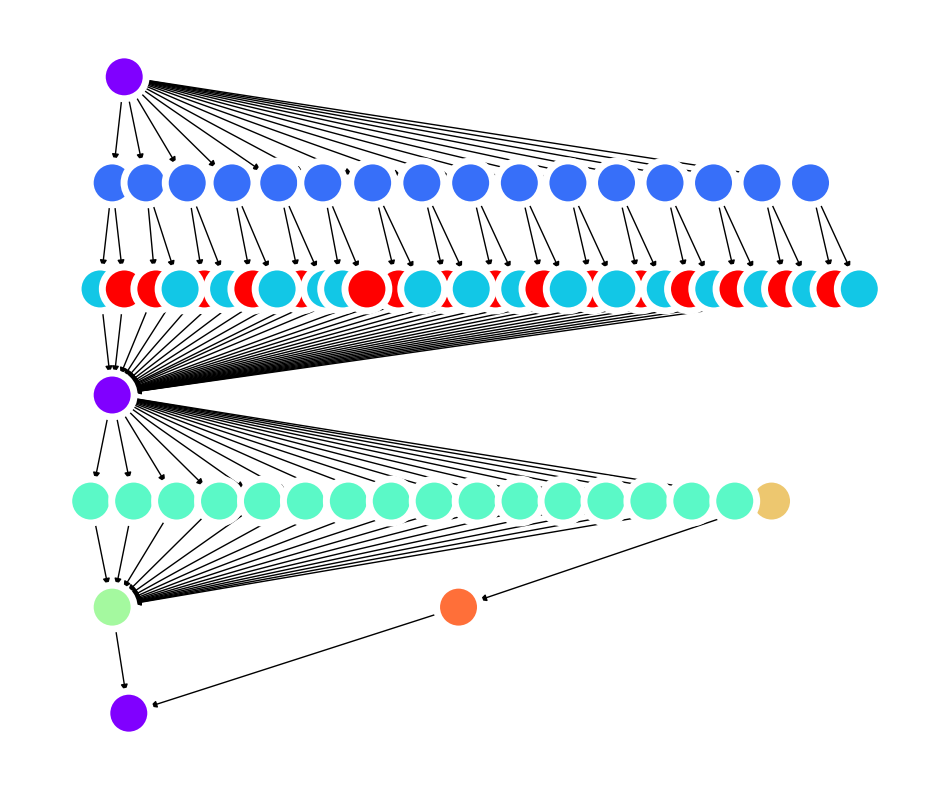

In [155]:
draw(decomposition_solver.division.complete_workflow.wf_instance.workflow)

In [104]:
WorkflowSchedulingOneHot(Workflow(tasks_file, machines_file, deadline))

KeyboardInterrupt: 

In [101]:
WorkflowSchedulingOneHot(solver.division.complete_workflow)

KeyboardInterrupt: 

In [105]:
after_div = SeriesParallelSplitFinal().create_sp_workflow(workflow_no_division)

In [123]:
spization: SpIzationAlgorithm = JavaFacadeSpIzationAlgorithm()
sp_dag = spization.run(Workflow(tasks_file, machines_file, deadline).wf_instance.workflow)
root = [node for node in sp_dag.nodes if sp_dag.in_degree(node) == 0][0]
leaf = [node for node in sp_dag.nodes if sp_dag.out_degree(node) == 0][0]
paths = list(nx.all_simple_paths(sp_dag, root, leaf))

# Find montage workflow ith constraints between 9000 and 17000

In [129]:
montage_to_explore = [
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-015d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-04d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-125d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-03d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-075d-001.json",
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-05d-001.json"
]
machines_file = "../workflows_data/machines/linear_smaller_diff.json"
deadline = 100000

divisions = [0.4, 0.5, 0.6, 0.7, 0.8]

In [100]:
def constraints_per_mss(divisions: list, tasks_file, machines_file, deadline):
    n_tasks = len(Workflow(tasks_file, machines_file, deadline).tasks)
    max_subgraph_sizes = [int(d * n_tasks) for d in divisions]
    result = {}
    for mss in max_subgraph_sizes:
        division = SeriesParallelSplitFinal().decompose(Workflow(tasks_file, machines_file, deadline), mss)
        path_len = [len(w.paths) for w in division.workflows]
        task_count = [len(w.tasks) for w in division.workflows]
        result[mss] = max([p + t for p, t in zip(path_len, task_count)])
    return result

In [104]:
m_310_path_sizes = constraints_per_mss(divisions, montage_to_explore[0], machines_file, deadline)

In [116]:
m_1312_path_sizes = constraints_per_mss([0.27], montage_to_explore[1], machines_file, deadline)

In [114]:
m_1066_path_sizes = constraints_per_mss([0.33], montage_to_explore[2], machines_file, deadline)

In [111]:
m_784_path_sizes = constraints_per_mss([0.3, 0.4], montage_to_explore[3], machines_file, deadline)

In [127]:
m_178_path_sizes = constraints_per_mss([1.035], montage_to_explore[4], machines_file, deadline)

In [130]:
m_1738_path_sizes = constraints_per_mss([0.1], montage_to_explore[5], machines_file, deadline)

# Determine problem size limit for CQM

In [97]:
scheduled_instances = [
    "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-12ch-250k-001.json", #genome 492
    "/home/marcin/Programming/pegasus-instances/1000genome/chameleon-cloud/1000genome-chameleon-22ch-250k-001.json", #genome 902
    "/home/marcin/Programming/pegasus-instances/epigenomics/chameleon-cloud/epigenomics-chameleon-ilmn-5seq-50k-001.json", #epigenomics 1397
    "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-5l-2c-12p-001.json", #cycles 2182
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-075d-001.json", #montage 178
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-2mass-015d-001.json", #montage 310
    "/home/marcin/Programming/pegasus-instances/cycles/chameleon-cloud/cycles-chameleon-10l-3c-12p-001.json", #cycles 6543
    "/home/marcin/Programming/pegasus-instances/montage/chameleon-cloud/montage-chameleon-dss-10d-001.json" #montage 472
]

scheduled_costs_cqm = [
    538035.2364480004,
    798343.3159296,
    342404.63156160025,
    629772.0476999999,
    636076.4203007995,
    None,
    1152230.944951188,
    None
]

scheduled_costs_gurobi = [
    536918.5248672002,
    791073.0919296001,
    342211.9858272003,
    629754.7669775992,
    625425.0246143986,
    12324.219839999982,
    1152212.017915186,
    1216670.6667935976
]

Montage 310 10s also no solution
Montage 472 13 sec no solution

In [98]:
def create_df_for_scheduled_instances(scheduled_instances, scheduled_costs_cqm, scheduled_costs_gurobi):
    def create_record(tasks_file, cqm_cost, gurobi_cost):
        workflow = Workflow(
            tasks_file,
            "../workflows_data/machines/linear_smaller_diff.json",
            1000000
        )
        problem = WorkflowSchedulingOneHot(workflow)
        return {
            "workflow_name": tasks_file,
            "workflow_size": len(workflow.tasks),
            "variables_count": len(problem.variables),
            "constraints_count": len(problem.constraints),
            "cqm_cost": cqm_cost,
            "gurobi_cost": gurobi_cost,
            "cost_increase": cqm_cost/gurobi_cost if cqm_cost else None
        }
    
    return pd.DataFrame([create_record(t, c, g) for t, c, g in zip(scheduled_instances, scheduled_costs_cqm, scheduled_costs_gurobi)])

In [99]:
scheduling_results: pd.DataFrame = create_df_for_scheduled_instances(scheduled_instances, scheduled_costs_cqm, scheduled_costs_gurobi)

In [100]:
scheduling_results.to_csv(os.path.join("cqm_scheduling", "cqm_limits", "scheduled_instances.csv"))

## Analyze what has an influence on scheduling quality

In [72]:
without_na = scheduling_results.fillna(100)

In [73]:
variables = without_na['variables_count']
constraints = without_na['constraints_count']
cost_increase = without_na['cost_increase']

In [75]:
correlation_variables_cost_increase = stats.pearsonr(variables, cost_increase)[0]
correlation_constraints_cost_increase = stats.pearsonr(constraints, cost_increase)[0]
print(f"Variables cost increase correlation: {correlation_variables_cost_increase}")
print(f"Constraints cost increase correlation: {correlation_constraints_cost_increase}")

Variables cost increase correlation: -0.2765660347325677
Constraints cost increase correlation: 0.9123363687715258
